# NYISO Energy Data — Exploratory Data Analysis
**Project 01: Data Pipeline & EDA**

This notebook walks through:
1. Fetching real NYISO data via the public CSV API
2. Cleaning and structuring the time series
3. Exploratory analysis: load patterns, price distributions, fuel mix
4. Visual insights that will feed into the forecasting model (Project 02)

> **Note:** If you're offline or want to run quickly without hitting NYISO servers, set `USE_SYNTHETIC = True` in the Config cell. The synthetic data mimics real NYISO patterns for development/demo purposes.

---

## 0. Setup & Config

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ── Config ────────────────────────────────────────────────────────────────────
USE_SYNTHETIC = False     # Set True to skip API calls and use generated data
START_DATE    = datetime(2024, 1, 1)
END_DATE      = datetime(2024, 3, 31)   # 3 months is enough for good EDA
DATA_DIR      = '../data/raw'
PROC_DIR      = '../data/processed'

print('Setup complete.')

Setup complete.


## 1. Data Ingestion

We pull three datasets from NYISO's public CSV API:
- **Actual Load** (`pal`) — hourly MW consumption by zone
- **Day-Ahead LMP** (`damlbmp`) — locational marginal prices ($/MWh) by zone
- **Fuel Mix** (`rtfuelmix`) — generation MW by fuel type (gas, nuclear, hydro, wind, etc.)

In [2]:
from nyiso_client import fetch_date_range
from clean import clean, make_hourly, pivot_zones
import os

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PROC_DIR, exist_ok=True)

if USE_SYNTHETIC:
    # ── Synthetic data generator (mimics NYISO patterns) ─────────────────────
    # Useful for development without hitting live servers
    print('Generating synthetic NYISO-like data...')
    from generate_synthetic import make_synthetic_data
    df_load, df_lmp, df_fuel = make_synthetic_data(START_DATE, END_DATE)
else:
    # ── Live NYISO API fetch ──────────────────────────────────────────────────
    print('Fetching live data from NYISO...')
    print('This will take ~30-60 seconds for a 3-month range.\n')
    
    raw_load = fetch_date_range('load_actual', START_DATE, END_DATE, save_dir=DATA_DIR)
    raw_lmp  = fetch_date_range('lmp_dayahead', START_DATE, END_DATE, save_dir=DATA_DIR)
    raw_fuel = fetch_date_range('fuel_mix', START_DATE, END_DATE, save_dir=DATA_DIR)

    df_load = clean(raw_load, 'load_actual')
    df_lmp  = clean(raw_lmp,  'lmp_dayahead')
    df_fuel = clean(raw_fuel, 'fuel_mix')

print(f'Load data:    {df_load.shape}')
print(f'LMP data:     {df_lmp.shape}')
print(f'Fuel mix:     {df_fuel.shape}')

2026-02-22 01:19:42,021 [INFO] Fetching load_actual for 2024-01-01 ...


Fetching live data from NYISO...
This will take ~30-60 seconds for a 3-month range.



2026-02-22 01:19:45,136 [INFO]   ✓ 100023 rows fetched
2026-02-22 01:19:45,967 [INFO] Fetching load_actual for 2024-02-01 ...
2026-02-22 01:19:49,349 [INFO]   ✓ 93555 rows fetched
2026-02-22 01:19:50,002 [INFO] Fetching load_actual for 2024-03-01 ...
2026-02-22 01:19:52,896 [INFO]   ✓ 99594 rows fetched
2026-02-22 01:19:53,585 [INFO] Fetching lmp_dayahead for 2024-01-01 ...
2026-02-22 01:19:53,886 [INFO]   ✓ 11160 rows fetched
2026-02-22 01:19:54,417 [INFO] Fetching lmp_dayahead for 2024-02-01 ...
2026-02-22 01:19:54,622 [INFO]   ✓ 10440 rows fetched
2026-02-22 01:19:55,151 [INFO] Fetching lmp_dayahead for 2024-03-01 ...
2026-02-22 01:19:55,348 [INFO]   ✓ 11145 rows fetched
2026-02-22 01:19:55,881 [INFO] Fetching fuel_mix for 2024-01-01 ...
2026-02-22 01:19:59,473 [INFO]   ✓ 63637 rows fetched
2026-02-22 01:20:00,077 [INFO] Fetching fuel_mix for 2024-02-01 ...
2026-02-22 01:20:02,093 [INFO]   ✓ 59535 rows fetched
2026-02-22 01:20:02,780 [INFO] Fetching fuel_mix for 2024-03-01 ...
2026-

Load data:    (293172, 6)
LMP data:     (32745, 9)
Fuel mix:     (186550, 5)


In [20]:
# Quick sanity check on the load data
df_load.head(12)

,timestamp,Time Zone,zone,PTID,load_mw,load_mw_outlier
0,2024-01-01 00:00:00-05:00,NaN,CAPITL,61757,1184.9514,False
1,2024-01-01 00:00:00-05:00,NaN,CENTRL,61754,1613.0529,False
2,2024-01-01 00:00:00-05:00,NaN,DUNWOD,61760,562.7285,False
3,2024-01-01 00:00:00-05:00,NaN,GENESE,61753,981.6057,False
4,2024-01-01 00:00:00-05:00,NaN,HUD VL,61758,1010.8683,False
5,2024-01-01 00:00:00-05:00,NaN,LONGIL,61762,2007.6326,False
6,2024-01-01 00:00:00-05:00,NaN,MHK VL,61756,834.1498,False
7,2024-01-01 00:00:00-05:00,NaN,MILLWD,61759,289.0521,False
8,2024-01-01 00:00:00-05:00,NaN,N.Y.C.,61761,4738.2417,False
9,2024-01-01 00:00:00-05:00,NaN,NORTH,61755,713.5773,False


In [19]:
# Check date coverage and missing timestamps
def check_coverage(df, name):
    ts = df['timestamp']
    # Only check nulls on actual data columns, not metadata like Time Zone
    data_cols = [c for c in df.columns if c not in ('timestamp', 'Time Zone')]
    null_count = df[data_cols].isnull().sum().sum()
    
    print(f'\n{name}')
    print(f'  Range:   {ts.min()} → {ts.max()}')
    print(f'  Rows:    {len(df):,}')
    print(f'  Nulls:   {null_count}')
    
check_coverage(df_load, 'Actual Load')
check_coverage(df_lmp,  'Day-Ahead LMP')
check_coverage(df_fuel, 'Fuel Mix')


Actual Load
  Range:   2024-01-01 00:00:00-05:00 → 2024-03-31 23:55:00-04:00
  Rows:    293,172
  Nulls:   0

Day-Ahead LMP
  Range:   2024-01-01 00:00:00-05:00 → 2024-03-31 23:00:00-04:00
  Rows:    32,745
  Nulls:   0

Fuel Mix
  Range:   2024-01-01 00:05:00-05:00 → 2024-04-01 00:00:00-04:00
  Rows:    186,550
  Nulls:   0


## 2. Load Analysis

### 2a. System-wide load over time

NYISO's total system load is the sum across all 11 zones. Let's look at the shape of demand across our date range.

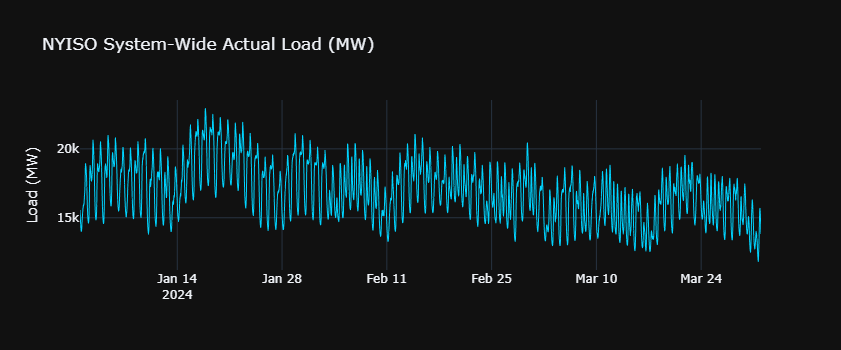

In [6]:
# Aggregate to total system load per timestamp
df_system = (
    df_load
    .groupby('timestamp')['load_mw']
    .sum()
    .reset_index()
    .rename(columns={'load_mw': 'total_load_mw'})
)

fig = px.line(
    df_system,
    x='timestamp', y='total_load_mw',
    title='NYISO System-Wide Actual Load (MW)',
    labels={'total_load_mw': 'Load (MW)', 'timestamp': ''},
    template='plotly_dark'
)
fig.update_traces(line_color='#00d4ff', line_width=1)
fig.update_layout(height=350)
fig.show()

### 2b. Load by zone — which zones drive peak demand?

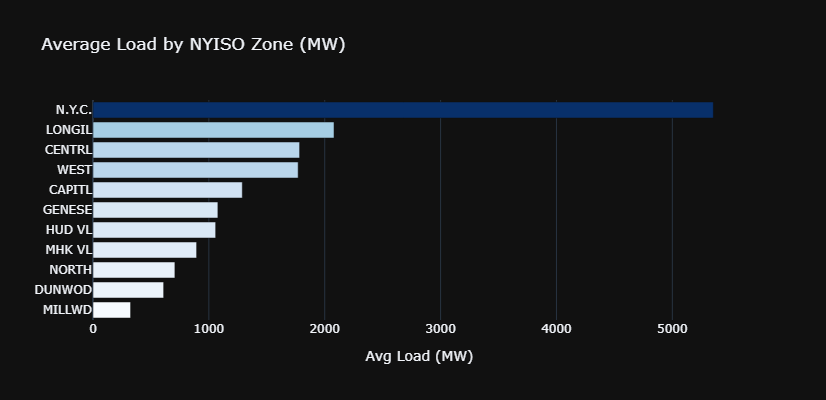

In [21]:
# Average load per zone
zone_avg = (
    df_load
    .groupby('zone')['load_mw']
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)

fig = px.bar(
    zone_avg,
    x='load_mw', y='zone',
    orientation='h',
    title='Average Load by NYISO Zone (MW)',
    labels={'load_mw': 'Avg Load (MW)', 'zone': ''},
    color='load_mw',
    color_continuous_scale='Blues',
    template='plotly_dark'
)
fig.update_layout(height=400, coloraxis_showscale=False)
fig.show()



N.Y.C. and LONGIL dominate — they typically account for ~60% of total load.

### 2c. Hourly load profile — the "duck curve" pattern

The average load by hour of day reveals the classic electricity demand shape: overnight trough, morning ramp, mid-day plateau, evening peak.

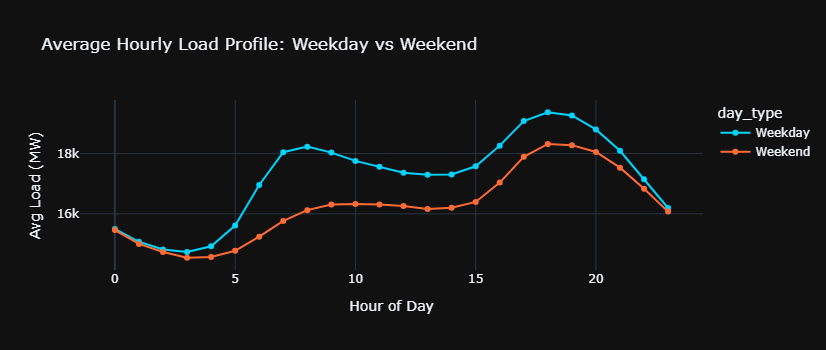

In [22]:
df_system['hour']       = df_system['timestamp'].dt.hour
df_system['day_of_week']= df_system['timestamp'].dt.day_name()
df_system['month']      = df_system['timestamp'].dt.month
df_system['is_weekend'] = df_system['timestamp'].dt.dayofweek >= 5

hourly_profile = (
    df_system
    .groupby(['hour', 'is_weekend'])['total_load_mw']
    .mean()
    .reset_index()
)
hourly_profile['day_type'] = hourly_profile['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

fig = px.line(
    hourly_profile,
    x='hour', y='total_load_mw',
    color='day_type',
    title='Average Hourly Load Profile: Weekday vs Weekend',
    labels={'total_load_mw': 'Avg Load (MW)', 'hour': 'Hour of Day'},
    color_discrete_map={'Weekday': '#00d4ff', 'Weekend': '#ff6b35'},
    template='plotly_dark',
    markers=True
)
fig.update_layout(height=350)
fig.show()

Key insight: Weekday load is ~10-15% higher than weekends.
Both show a morning ramp (~6AM) and evening peak (~7-8PM) — critical for forecasting.

### 2d. Load heatmap — day × hour

This is one of the most informative views for energy analysts. Each cell is the average load for that hour-of-day × day-of-week combination.

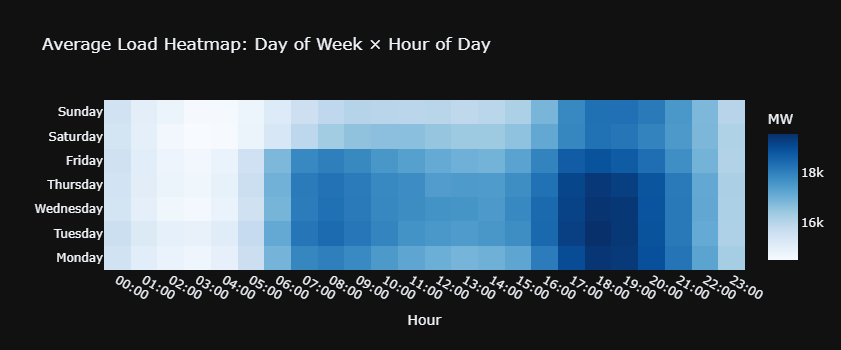

In [9]:
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

heatmap_data = (
    df_system
    .groupby(['day_of_week', 'hour'])['total_load_mw']
    .mean()
    .reset_index()
    .pivot(index='day_of_week', columns='hour', values='total_load_mw')
    .reindex(dow_order)
)

fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=[f'{h:02d}:00' for h in range(24)],
    y=dow_order,
    colorscale='Blues',
    colorbar=dict(title='MW')
))
fig.update_layout(
    title='Average Load Heatmap: Day of Week × Hour of Day',
    template='plotly_dark',
    height=350,
    xaxis_title='Hour',
    yaxis_title=''
)
fig.show()

## 3. LMP Price Analysis

Locational Marginal Prices (LMP) represent the cost of electricity at each grid location. They're the primary price signal in wholesale energy markets.

High LMP periods are when avoided energy has the most financial value

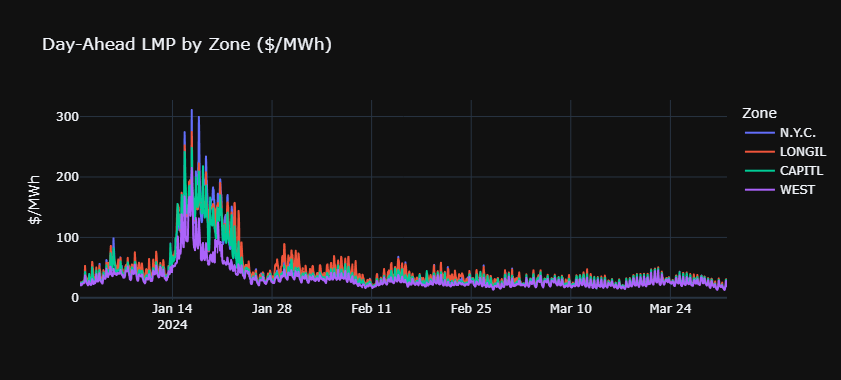

In [10]:
# Pivot to wide format: one column per zone
lmp_wide = pivot_zones(df_lmp, 'lmp_total')

# NYC vs. rest of state — usually NYC is highest due to congestion
zones_to_plot = ['N.Y.C.', 'LONGIL', 'CAPITL', 'WEST']
available = [z for z in zones_to_plot if z in lmp_wide.columns]

fig = px.line(
    lmp_wide,
    x='timestamp',
    y=available,
    title='Day-Ahead LMP by Zone ($/MWh)',
    labels={'value': '$/MWh', 'timestamp': '', 'variable': 'Zone'},
    template='plotly_dark'
)
fig.update_layout(height=380)
fig.show()

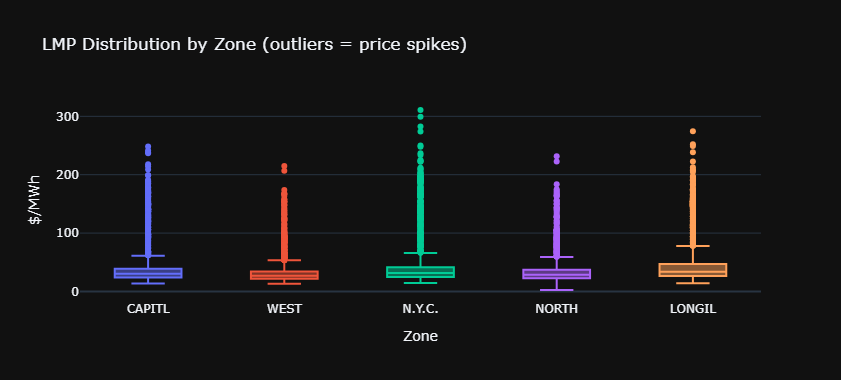


LMP Summary by Zone ($/MWh):
         mean  median    std     max
zone                                
LONGIL  45.79   33.75  35.76  274.46
N.Y.C.  43.38   31.49  38.12  310.85
NPX     42.36   31.58  32.62  249.00
DUNWOD  40.86   31.06  32.60  277.36
CAPITL  40.84   30.43  33.79  248.29
MILLWD  40.61   30.90  32.12  261.34
HUD VL  40.22   30.69  31.64  256.49
MHK VL  36.80   29.97  24.62  249.71
PJM     36.51   28.90  26.26  241.00
CENTRL  35.03   28.88  22.76  236.25
H Q     33.98   28.90  21.07  233.17
NORTH   33.89   28.66  21.37  231.53
GENESE  33.29   27.50  21.51  223.26
WEST    32.67   26.90  20.85  215.00
O H     31.14   26.30  17.63  163.59


In [11]:
# Price distribution — looking for spikes
fig = px.box(
    df_lmp[df_lmp['zone'].isin(['N.Y.C.', 'LONGIL', 'CAPITL', 'WEST', 'NORTH'])],
    x='zone', y='lmp_total',
    title='LMP Distribution by Zone (outliers = price spikes)',
    labels={'lmp_total': '$/MWh', 'zone': 'Zone'},
    color='zone',
    template='plotly_dark'
)
fig.update_layout(height=380, showlegend=False)
fig.show()

# Summary stats
print('\nLMP Summary by Zone ($/MWh):')
print(
    df_lmp.groupby('zone')['lmp_total']
    .agg(['mean','median','std','max'])
    .round(2)
    .sort_values('mean', ascending=False)
)

## 4. Fuel Mix Analysis

What generates the electricity? NYISO's fuel mix shows the real-time contribution of each source — this is the "carbon content" signal and is increasingly important for ESG reporting and demand-side programs.

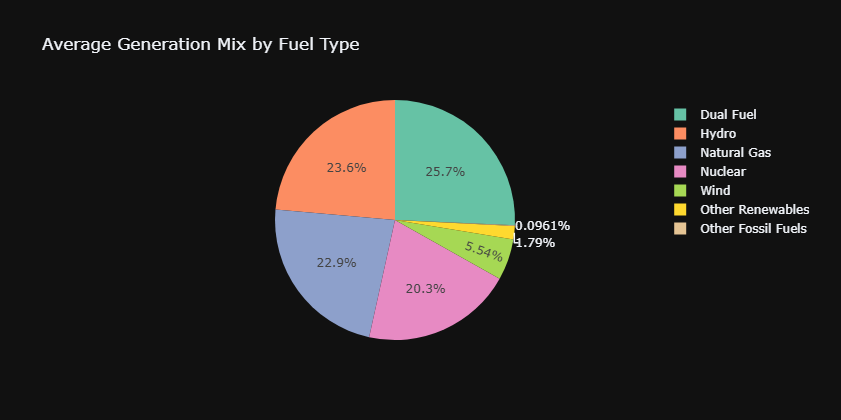

In [12]:
# Average generation by fuel type
fuel_avg = (
    df_fuel
    .groupby('fuel_type')['gen_mw']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

fig = px.pie(
    fuel_avg,
    values='gen_mw',
    names='fuel_type',
    title='Average Generation Mix by Fuel Type',
    template='plotly_dark',
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_layout(height=420)
fig.show()

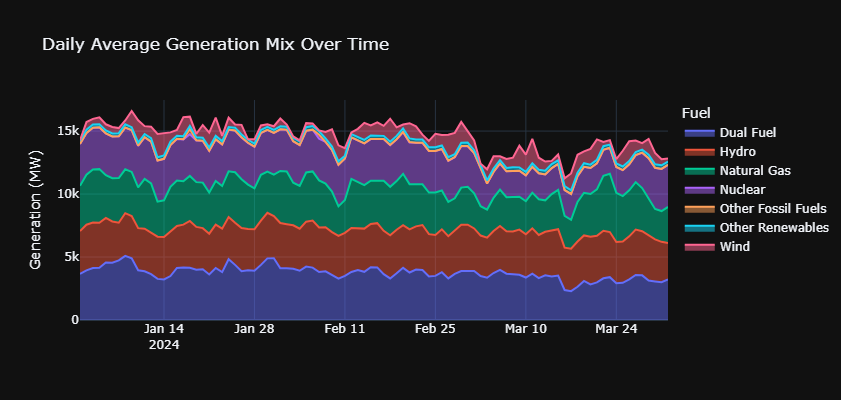

In [13]:
# Fuel mix over time — stacked area chart
fuel_hourly = (
    df_fuel
    .set_index('timestamp')
    .groupby('fuel_type')
    .resample('D')['gen_mw']  # daily average to keep chart readable
    .mean()
    .reset_index()
)

fig = px.area(
    fuel_hourly,
    x='timestamp', y='gen_mw',
    color='fuel_type',
    title='Daily Average Generation Mix Over Time',
    labels={'gen_mw': 'Generation (MW)', 'timestamp': '', 'fuel_type': 'Fuel'},
    template='plotly_dark'
)
fig.update_layout(height=400)
fig.show()

## 5. Cross-Dataset Insights

### 5a. Load vs. Price correlation
Does higher load always mean higher prices? Not always — congestion and fuel costs matter too.

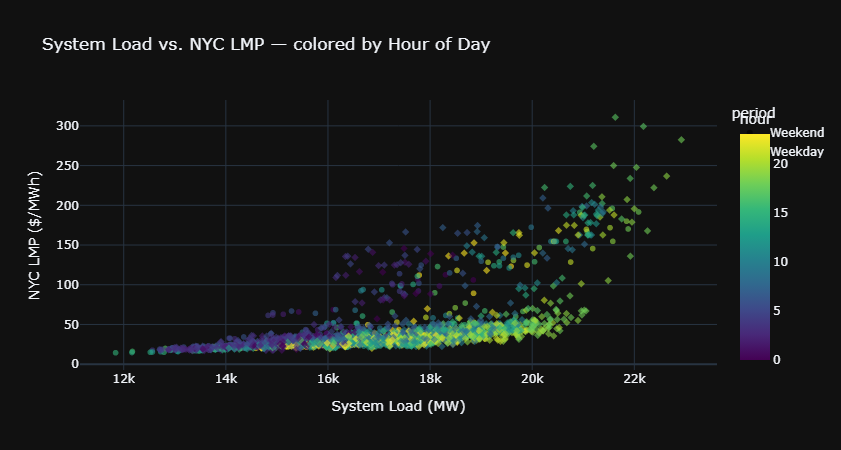


Load–Price Pearson correlation: 0.604
High correlation = price is load-driven. Low = congestion/fuel dominate.


In [14]:
# Merge system load with NYC LMP for scatter analysis
nyc_lmp = df_lmp[df_lmp['zone'] == 'N.Y.C.'][['timestamp','lmp_total']]

df_merged = pd.merge(
    df_system[['timestamp','total_load_mw','hour','is_weekend']],
    nyc_lmp,
    on='timestamp',
    how='inner'
)

df_merged['period'] = df_merged['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

fig = px.scatter(
    df_merged.sample(min(2000, len(df_merged))),  # sample for performance
    x='total_load_mw',
    y='lmp_total',
    color='hour',
    symbol='period',
    title='System Load vs. NYC LMP — colored by Hour of Day',
    labels={'total_load_mw': 'System Load (MW)', 'lmp_total': 'NYC LMP ($/MWh)'},
    template='plotly_dark',
    color_continuous_scale='Viridis',
    opacity=0.6
)
fig.update_layout(height=450)
fig.show()

corr = df_merged[['total_load_mw','lmp_total']].corr().iloc[0,1]
print(f'\nLoad–Price Pearson correlation: {corr:.3f}')
print('High correlation = price is load-driven. Low = congestion/fuel dominate.')

## 6. Save Processed Data

Save clean files for use in Project 02 (forecasting). Using parquet for speed and size efficiency.

In [15]:
import os
os.makedirs(PROC_DIR, exist_ok=True)

df_load.to_parquet(f'{PROC_DIR}/load_actual.parquet', index=False)
df_lmp.to_parquet(f'{PROC_DIR}/lmp_dayahead.parquet', index=False)
df_fuel.to_parquet(f'{PROC_DIR}/fuel_mix.parquet', index=False)
df_system.to_parquet(f'{PROC_DIR}/system_load.parquet', index=False)

print('Saved to data/processed/:')
for f in os.listdir(PROC_DIR):
    size = os.path.getsize(f'{PROC_DIR}/{f}') / 1024
    print(f'  {f}  ({size:.1f} KB)')

Saved to data/processed/:
  fuel_mix.parquet  (781.8 KB)
  lmp_dayahead.parquet  (206.1 KB)
  load_actual.parquet  (2570.2 KB)
  system_load.parquet  (478.0 KB)


## 7. Key Takeaways

After this EDA, we've established:

1. **Load follows strong time patterns** — hour of day, weekday vs weekend, and seasonal effects are all present. These become features in the forecasting model.

2. **NYC and Long Island dominate demand** — ~60% of system load. Zone-level models may outperform system-level ones.

3. **LMP is volatile and zone-dependent** — congestion causes prices to diverge significantly across zones. Price spike detection is a natural follow-on project.

4. **Natural gas is the marginal fuel** — setting prices most of the time. Renewable penetration (wind, hydro) provides price suppression during off-peak periods.

---

**Next:** Project 02 — Day-Ahead Load Forecasting using these features + weather data.